### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2504,2371,2,0,133,2437.5,1,133,0,34.0,...,1.0,1.0,0.0,0.0,0.0,41.0,39.0,1,6.0,2.0
1,2487,2596,1,0,109,2541.5,0,-109,0,20.0,...,1.0,1.0,1.0,1.0,2.0,33.0,31.0,1,13.0,2.0
2,2915,2921,1,0,6,2918.0,0,-6,0,32.0,...,1.0,1.0,0.0,0.0,0.0,31.0,37.0,1,6.0,-6.0
3,2542,2433,2,0,109,2487.5,1,109,10,26.0,...,1.0,0.0,1.0,0.0,1.0,34.0,28.0,0,7.0,6.0
4,2473,2658,0,0,185,2565.5,0,-185,0,28.0,...,1.0,1.0,3.0,0.0,3.0,30.0,35.0,1,9.0,-5.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3031382, 33)
Target: (3031382,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 31.02 seconds (0.52 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.6001 (60.01%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.57      0.61      0.59    249346
        Draw       0.87      0.28      0.42     81759
   White Win       0.60      0.68      0.64    275172

    accuracy                           0.60    606277
   macro avg       0.68      0.52      0.55    606277
weighted avg       0.63      0.60      0.59    606277



### 6. Confusion Matrix

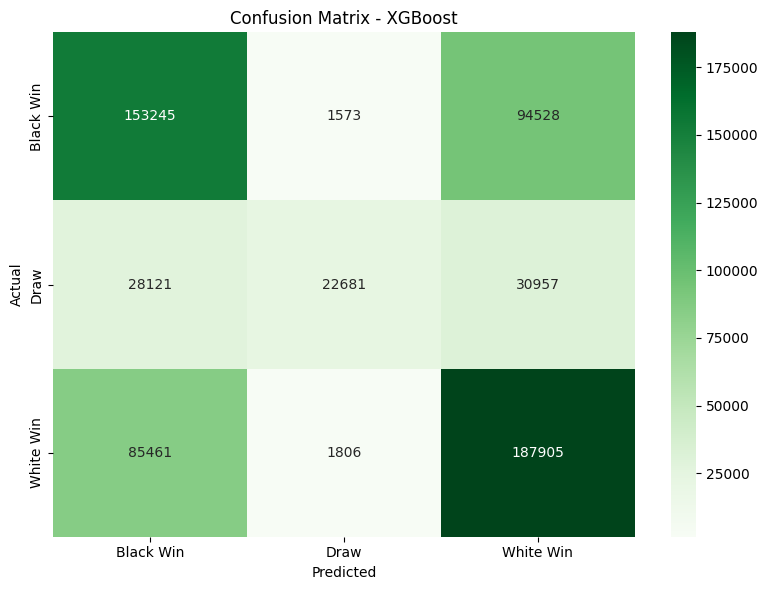

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
4               AvgRating    0.281461
6    WhiteRatingAdvantage    0.222884
0                WhiteElo    0.076281
3              RatingDiff    0.072822
1                BlackElo    0.053984
10    material_diff_early    0.039919
2             EventTypeID    0.035257
32          activity_diff    0.030576
8        w_material_early    0.022373
9        b_material_early    0.018652
23        w_castled_early    0.017325
24        b_castled_early    0.014172
30     both_castled_early    0.012078
15     b_aggression_early    0.010959
29       b_piece_activity    0.009522
13     capture_diff_early    0.009508
21          b_development    0.008557
16  aggression_diff_early    0.007400
28       w_piece_activity    0.007163
26         b_checks_early    0.006500
25         w_checks_early    0.004708
14     w_aggression_early    0.004593
22       development_diff    0.004204
11       w_captures_early    0.004090
12       b_captures_early    0.004053
20          

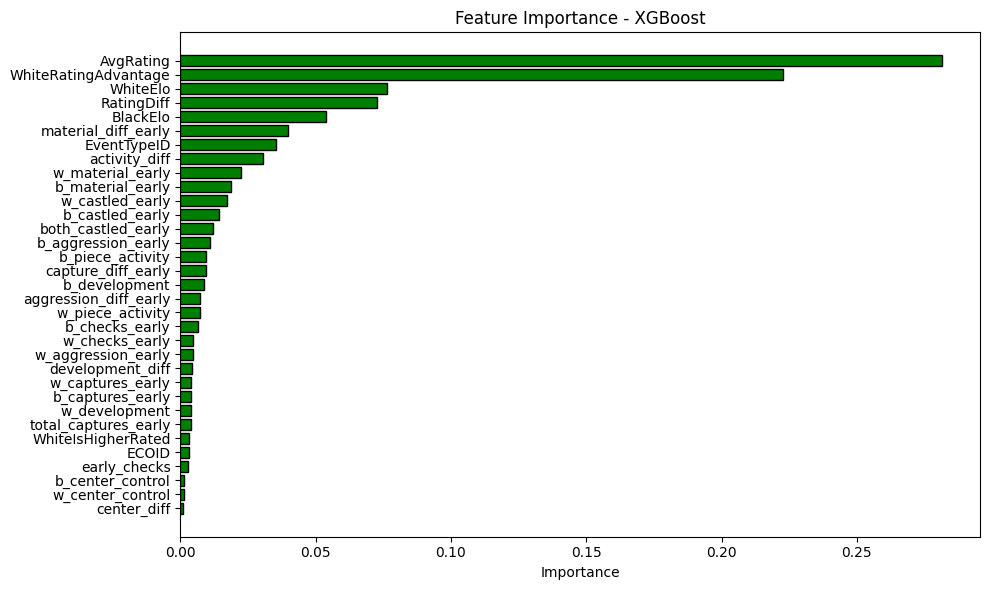

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()